In [133]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, we will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [103]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("../Resources/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [104]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Let's plot the "Settle" price to find  any patterns, long-term and/or short.
From the Plot it appears Yen Futures are inversely propotional to US dollar or stock market.  when US markets were down, Yen futures increased and it is seemnly apparent during dot com bubble, 911 aftermath, 2008 sub prime meltddown etc., 

<AxesSubplot:xlabel='Date'>

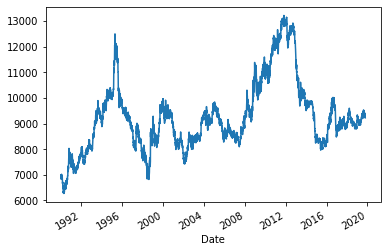

In [105]:
# Plot using the "Settle" column from the dataframe:
yen_futures['Settle'].plot()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [106]:
#  Using statsmodel module, Applying the Hodrick-Prescott Filterby decomposing the "Settle" price into two separate series:
import statsmodels.api as sm
futures_noice, futures_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [107]:
# Creating a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_futures_decomp = yen_futures['Settle'].to_frame()
yen_futures_decomp['Trend'] = futures_trend
yen_futures_decomp['Noise'] = futures_noice
yen_futures_decomp.head()

,Settle,Trend,Noise
Date,,,
1990-01-02,6847.0,6908.503967,-61.503967
1990-01-03,6887.0,6908.799756,-21.799756
1990-01-04,7008.0,6909.057104,98.942896
1990-01-05,6950.0,6909.223948,40.776052
1990-01-08,6959.0,6909.310062,49.689938


<AxesSubplot:xlabel='Date'>

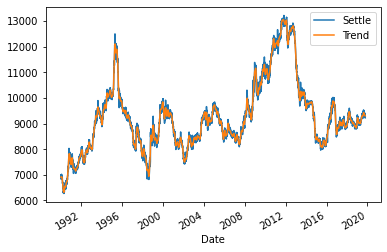

In [108]:
# Plot the Settle Price vs. the Trend for 2015 to the present
ax=yen_futures_decomp['Settle'].plot(legend=True)
yen_futures_decomp['Trend'].plot(ax=ax, legend=True)

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

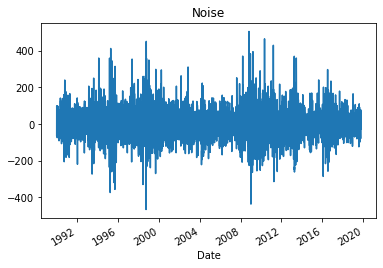

In [109]:
# Plot the Settle Noise
yen_futures_decomp['Noise'].plot(title='Noise')

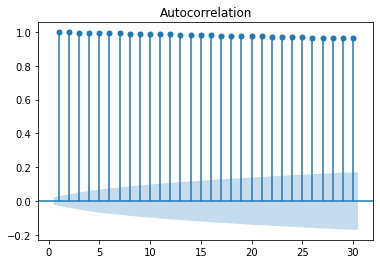

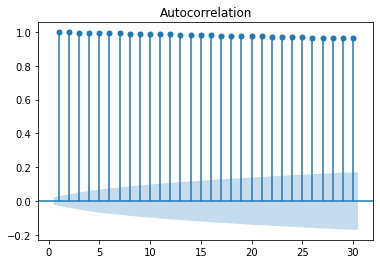

In [110]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# we will use PACF to identify optimal lags for our ARMA and ARIMA models with 30 day lags
plot_acf(yen_futures.Settle, lags=30, zero=False)

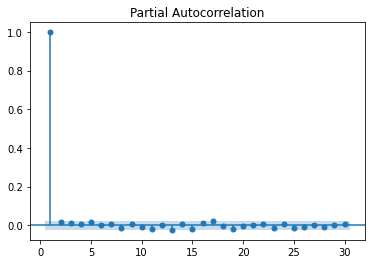

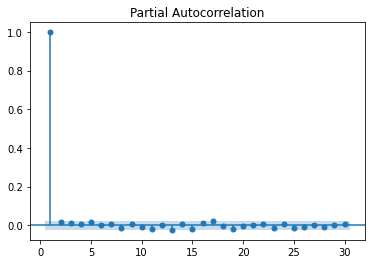

In [111]:
plot_pacf(yen_futures.Settle, lags=30, zero=False)

The above plots indicate that while there are more than 1 highly correlated lags in ACF, there is only one significant lag in PACF. we could use either 1 lag for AR and 1 for MA (p=1, q=1) or 2 to 5 for AR and 1 for MA (p=5, q=1) parameters in ARMA/ARIMA models. for our ARMA model we will use (p=1, q=1) and for ARIMA we will use (p=5, d=1, q=1)

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, let us estimate an ARMA model

1. Create an ARMA model and fit it to the returns data by setting the AR and MA ("p" and "q") to the order=(2, 1).
2. Output the ARMA summary table and review p-values of the lags. Based on the p-values, let us evaluate if the model a good fit (p < 0.05) or not.
3. finally lets Plot the 5-day forecast the results using forecast from ARMA model)

In [130]:
returns = (yen_futures["Settle"].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

Date
2019-10-09   -0.410601
2019-10-10   -0.369458
2019-10-11   -0.564304
2019-10-14    0.151335
2019-10-15   -0.469509
Name: Settle, dtype: float64

In [134]:
# Estimating ARMA model using statsmodels of order=(2, 1))
from statsmodels.tsa.arima_model import ARMA
model = ARMA(returns, order=(2,1))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 01 Oct 2020   AIC                          15798.142
Time:                        15:08:21   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3060      1.278     -0.240      0.811      -2.811       2.198
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2945      1.278      0.230      0.818      -2.210       2.799
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3368           +0.0000j            3.3368            0.5000
AR.2         -157.1987           +0.0000j          157.1987            0.5000
MA.1           -3.3958           +0.0000j            3.3958            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 day Yen Returns Forecast'}>

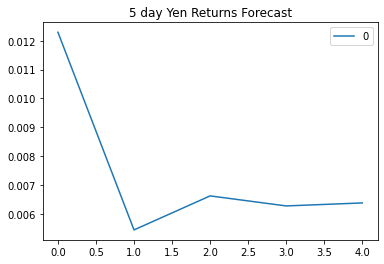

In [135]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 day Yen Returns Forecast")

## Observations
1. P values in the ARMA summary table are higher than 0.05, indicating the model is not a good fit. 
2. the 5 day returns time series forecast indicates 5% to 7% drop in Yen Furures Returns. 

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags

In [115]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(yen_futures['Settle'].values, order=(5,1,1))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Thu, 01 Oct 2020   AIC                          83905.238
Time:                        14:55:33   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.y      0.2825      0.699      0.404      0.686      -1.087       1.652
ar.L2.D.y      0.0007      0.016      0.043      0.965      -0.030       0.032
ar.L3.D.y     -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.y     -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.y     -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.y     -0.2975      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8921           -1.3782j            2.3408           -0.1002
AR.2            1.8921           +1.3782j            2.3408            0.1002
AR.3           -2.2712           -3.0199j            3.7787           -0.3526
AR.4           -2.2712           +3.0199j            3.7787            0.3526
AR.5          -11.1125           -0.0000j           11.1125           -0.5000
MA.1            3.3611           +0.0000j            3.3611            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 day Yen Futures Forecast'}>

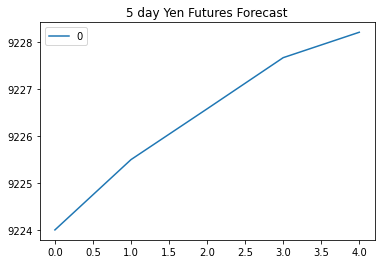

In [116]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 day Yen Futures Forecast")

## Observations
1. P values in the ARIMA summary table are higher than 0.05, indicating the model is not a good fit. 
2. the 5 day futures time series forecast indicates fractional increase in Yen Furures Returns. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model
1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the P-values of the lags. Based on the p-values, we can evaluate if the model is a good fit if P < 0.05.
3. We will then Plot the 5-day forecast of the volatility.

In [136]:
# Estimating a GARCH model:
from arch import arch_model
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)
res = model.fit(disp="off")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Thu, Oct 01 2020   Df Residuals:                     7510
Time:                        15:08:55   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

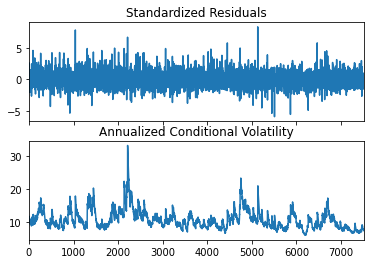

In [119]:
# Plotting the model estimate of the annualized volatility
fig = res.plot(annualize='D')

In [140]:
# let us Create a 5 day forecast of volatility using the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
forecast_horizon = 5
last_day

'2019-10-15'

In [137]:
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [138]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [139]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


<AxesSubplot:>

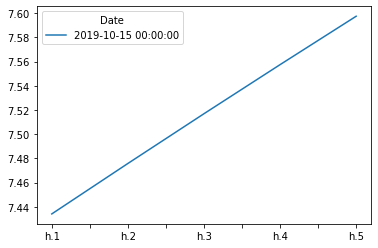

In [141]:
# Plot the final forecast
final.plot()

---

# Conclusions

Based on 5 day forecasted time series analysis, Yen futures are expected to hover around the mean however  considering the volatility forecast for the same 5 day duration, given the upward trend in the future volatility plot, the Yen Futures risk is expected to increase, indicating Yen futures are not a good buy in the short run.

Based on the model evaluation, it might appear for this specific instance that the model can be used in realtime trading. However in reality the model has not tested and proven to be used in realtime trading. We could be useful to test our hypothesis.